In [ ]:
from numba import cuda
import numpy as np
import time

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

**LAB 2**

In [ ]:
cuda.detect()

gpu = cuda.get_current_device()
num_processor = gpu.MULTIPROCESSOR_COUNT

print(f"Number of processors: {num_processor}")

free, total = cuda.current_context().get_memory_info()

print(f"Free: {free / (1024**3):.2f} GB")
print(f"Total {total/ (1024**3):.2f} GB")



Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-67bf9ad0-647f-8747-114b-984bb443b1b4
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
Number of processors: 40
Free: 14.64 GB
Total 14.74 GB


**LAB 3**

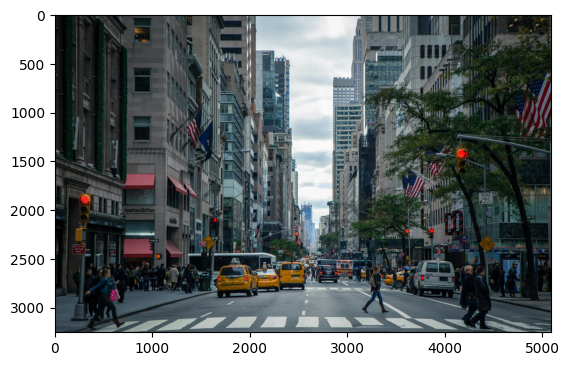

(3253, 5088, 3)
Number of pixels: 16551264
(16551264, 3)


In [ ]:
import matplotlib.pyplot as plt

image_path = "img2.jpg"

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

print(image.shape)

H, W, C = image.shape

pixel_count = H * W

print(f"Number of pixels: {pixel_count}")

flattened_image = image.reshape(pixel_count, 3)

print(flattened_image.shape)


In [ ]:

def gray_scale_cpu(flat_src):
    n = flat_src.shape[0]
    flat_dst = np.empty_like(flat_src)

    start = time.time()
    for i in range(n):
        g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)
        flat_dst[i, 0] = g
        flat_dst[i, 1] = g
        flat_dst[i, 2] = g
    end = time.time()


    return flat_dst, (end - start)

/tmp/ipython-input-3474370444.py:11: RuntimeWarning: overflow encountered in scalar add
  g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)


CPU grayscale done in 36.6088s


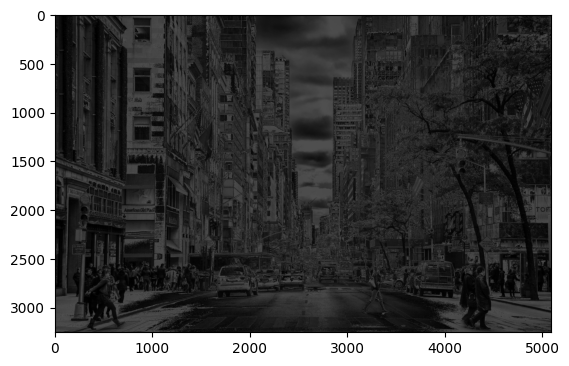

In [ ]:
gray_cpu_flatten, cpu_time = gray_scale_cpu(flattened_image)
print(f"CPU grayscale done in {cpu_time:.4f}s")
gray_cpu_image = gray_cpu_flatten.reshape(H, W, C)
plt.imshow(gray_cpu_image)
plt.show()

In [ ]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def grayscale_kernel(src, dst):
    i = cuda.grid(1)
    if i < src.shape[0]:
        g = np.uint8((src[i,0] + src[i,1] + src[i,2]) / 3)
        dst[i,0] = g
        dst[i,1] = g
        dst[i,2] = g

def grayscale_gpu(flat_img, nthreads=256):
    n = flat_img.shape[0]
    blocks = (n + nthreads - 1) // nthreads

    d_src = cuda.to_device(flat_img)
    d_dst = cuda.device_array_like(flat_img)

    start = time.time()
    grayscale_kernel[blocks, nthreads](d_src, d_dst)
    cuda.synchronize()
    end = time.time()

    print(f"GPU grayscale done in {end - start:.4f}s")
    return d_dst.copy_to_host(), end - start

thread = 64
GPU grayscale done in 0.0753s
thread = 128
GPU grayscale done in 0.0042s
thread = 256
GPU grayscale done in 0.0042s
thread = 1024
GPU grayscale done in 0.0045s


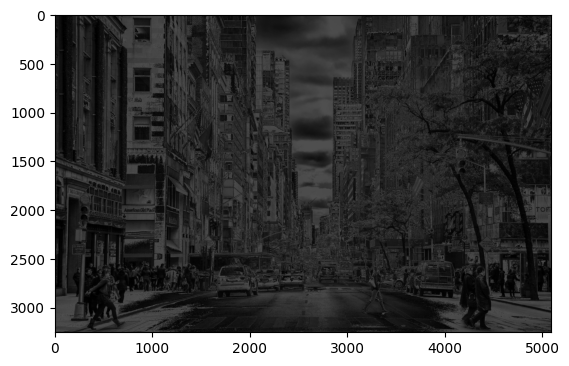

In [ ]:
threads = [64, 128, 256, 1024]
time_gpu = []
result = None

for nthread in threads:
  print(f"thread = {nthread}")
  image, gpu_time = grayscale_gpu(flattened_image, nthreads=nthread)
  time_gpu.append(gpu_time)
  if result is None:
    gray_img_gpu = image.reshape(H, W, 3)
    result = gray_cpu_image


plt.imshow(result)
plt.show()

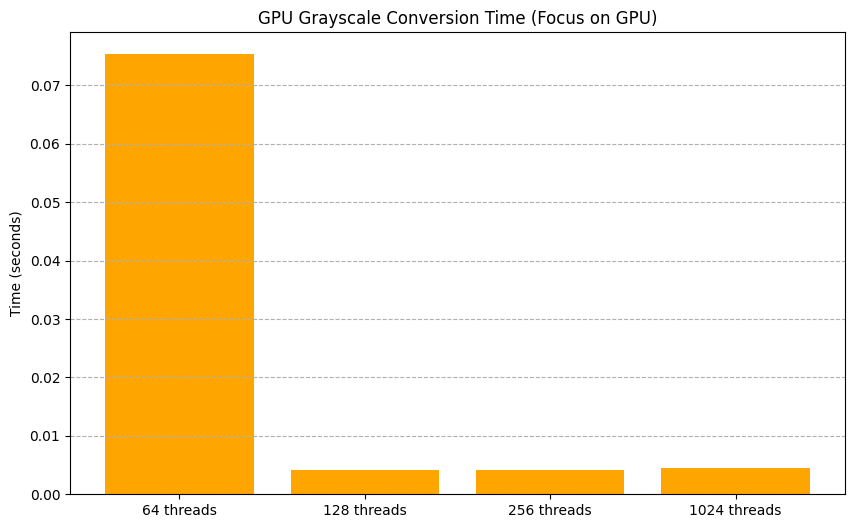

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar([f'{t} threads' for t in threads], time_gpu, color='orange')
plt.ylabel('Time (seconds)')
plt.title('GPU Grayscale Conversion Time (Focus on GPU)')
plt.grid(axis='y', linestyle='--')
plt.show()

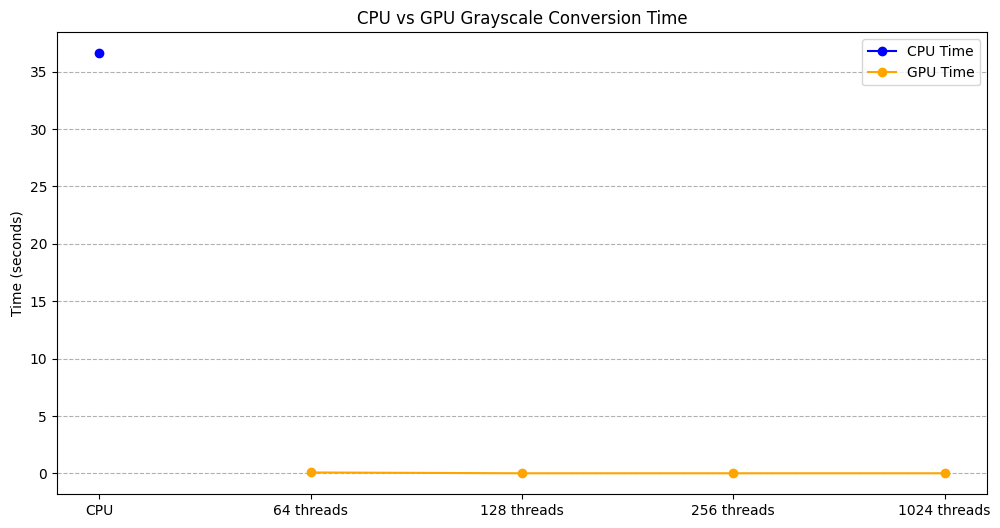

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['CPU'] + [f'{t} threads' for t in threads]
times = [cpu_time] + time_gpu

plt.figure(figsize=(12, 6))
plt.plot(['CPU'], [cpu_time], marker='o', label='CPU Time', color='blue')
plt.plot([f'{t} threads' for t in threads], time_gpu, marker='o', label='GPU Time', color='orange')
plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Grayscale Conversion Time')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()